# Qualitative Survey Response Analysis

My goal is to create a model that can analyze the sentiment of qualitative survey responses. This will help to automate the process of analyzing survey responses and increase data analytic efficiency!

## Set-up

We'll be using files saved on my Google Drive.

In [ ]:
#Mount the Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The following code is to manipulate the csv files to obtain the columns we want to use (ex. Labels and Survey Answers)

## Making the CV Files

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/UnERD/Processed_Combined2.csv')
sorted = df.sample(frac=1)

In [ ]:
question = sorted.Question
label_answer = sorted.drop('Question', axis = 1) # Axis 1 is the column, axis 0 is rows

In [ ]:
print(label_answer.head())

     Sentiment                                    Survey Response
75     neutral  Breakout rooms for a project course with the p...
0     positive  Extended time for test scenarios, removed stre...
248   positive  I prefer the inverted method, where the profes...
894   positive  The best teaching tool in this time was the li...
1006  negative  Full length pre recorded lectures i found were...


In [ ]:
# Only run this once
#label_answer.to_csv('/content/drive/My Drive/Colab Notebooks/UnERD/Model_V2/label_answer_cleaned.csv')
#question.to_csv('/content/drive/My Drive/Colab Notebooks/UnERD/Model_V2/question_cleaned.csv')

## Only Positive and Negative

In [ ]:
import pandas as pd

In [ ]:
current = pd.read_csv('/content/drive/My Drive/Colab Notebooks/UnERD/Model_V2/label_answer_cleaned8.csv', encoding='utf-8')

In [ ]:
print(current)

               label                                             answer
0            neutral                   Posting notes online on Quercus.
1     recommendation  It would be greatly appreciated if the Univers...
2           negative  One of my professors decided to cancel all cla...
3           positive  so it was reassuring to know that the lectures...
4           negative  Instructor posted content prior to the class a...
...              ...                                                ...
1253        negative  Remote Desktop also would fail sometimes and w...
1254        negative  if the professors had not opted to aslo post r...
1255        positive  I liked having online lectures during schedule...
1256         neutral  pre recorded lectures played during a live ses...
1257         neutral                              Pre recorded lectures

[1258 rows x 2 columns]


In [ ]:
length = len(current.label)
print(length)

1258


In [ ]:
print(current)

               label                                             answer
0            neutral                   Posting notes online on Quercus.
1     recommendation  It would be greatly appreciated if the Univers...
2           negative  One of my professors decided to cancel all cla...
3           positive  so it was reassuring to know that the lectures...
4           negative  Instructor posted content prior to the class a...
...              ...                                                ...
1253        negative  Remote Desktop also would fail sometimes and w...
1254        negative  if the professors had not opted to aslo post r...
1255        positive  I liked having online lectures during schedule...
1256         neutral  pre recorded lectures played during a live ses...
1257         neutral                              Pre recorded lectures

[1258 rows x 2 columns]


In [ ]:
current.drop(current[current['label'] == 'neutral'].index, inplace = True) 

In [ ]:
current.drop(current[current['label'] == 'recommendation'].index, inplace = True) 

In [ ]:
print(current)

         label                                             answer
2     negative  One of my professors decided to cancel all cla...
3     positive  so it was reassuring to know that the lectures...
4     negative  Instructor posted content prior to the class a...
5     positive             prerecorded lectures help me the most.
7     negative  Recording lectures outside of the lecture time...
...        ...                                                ...
1251  positive  Live lectures held at normal class times are v...
1252  negative  Although the profs were organized and did thei...
1253  negative  Remote Desktop also would fail sometimes and w...
1254  negative  if the professors had not opted to aslo post r...
1255  positive  I liked having online lectures during schedule...

[982 rows x 2 columns]


In [ ]:
current.to_csv('/content/drive/My Drive/Colab Notebooks/UnERD/Model_V2/use_this_one.csv')

In [ ]:
new = pd.read_csv('/content/drive/My Drive/Colab Notebooks/UnERD/Model_V2/use_this_one.csv', encoding='utf-8-sig')
cnt_total = 0
cnt_neg = 0
cnt_pos = 0
print(new.head())

   Unnamed: 0     label                                             answer
0           2  negative  One of my professors decided to cancel all cla...
1           3  positive  so it was reassuring to know that the lectures...
2           4  negative  Instructor posted content prior to the class a...
3           5  positive             prerecorded lectures help me the most.
4           7  negative  Recording lectures outside of the lecture time...


In [ ]:
cnt_total = len(new.label)
cnt_neg = len(new[new['label']=='negative'])
cnt_pos = len(new[new['label']=='positive'])
print (cnt_total, cnt_neg, cnt_pos)


982 425 557


## Set up the input data

We load the data now and start building the pre-requisites for the model.

In [ ]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt

# file location (make sure to use your file location)
file_dir = '/content/drive/My Drive/Colab Notebooks/UnERD/Model_V2/'

def get_data():
    return csv.reader(open(file_dir + "use_this_one.csv","rt", encoding="utf-8-sig"))

def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

Let's check out the data we're working with:

In [ ]:
# print only the first tweet
cnt = 0
for i, line in enumerate(get_data()):
    print(line)
    cnt +=1
    if cnt == 10:
        break

['', 'label', 'answer']
['2', 'negative', 'One of my professors decided to cancel all classes starting from March 15th onwards and he sent us a list of textbook readings that would cover the content in the class since he was unable to put together an online system for the lectures. While I understood his reasoning, I definitely did not feel as if I was able to learn the second half of the course content as well.']
['3', 'positive', 'so it was reassuring to know that the lectures would be available if we slept in past a 9am.']
['4', 'negative', 'Instructor posted content prior to the class and used the online session to answer questions and elaborate concepts - this would work if the online session was a dedicated office hour, but not as a complete replacement to lectures.']
['5', 'positive', 'prerecorded lectures help me the most.']
['7', 'negative', 'Recording lectures outside of the lecture time and then using the actual lecture time as a Q&A session felt very unhelpful. This is beca

GloVe Embeddings will be used!

In [ ]:
glove = torchtext.vocab.GloVe(name="6B", dim=50) # use 10k most common words

.vector_cache/glove.6B.zip: 862MB [06:40, 2.15MB/s]                           
100%|█████████▉| 399577/400000 [00:13<00:00, 31389.99it/s]

In [ ]:
# verify that each survey response has a reasonable number of words
# that have GloVe embeddings
for i, line in enumerate(get_data()):
    if i > 30:
        break
    print(sum(int(w in glove.stoi) for w in split_tweet(line[-1])))

1
73
20
41
7
85
84
25
53
42
28
55
12
36
10
27
34
11
8
17
15
23
56
68
20
14
23
42
21
45
10


Split into Training, Validation, and Testing sets.

### Ignore this

In [ ]:
import torch
import torch.nn as nn

def get_tweet_words(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(get_data()):
        if line[0] == 'recommendation':
            continue
        tweet = line[-1]
        idxs = [glove_vector.stoi[w]        # lookup the index of word
                for w in split_tweet(tweet)
                if w in glove_vector.stoi] # keep words that has an embedding
        if not idxs: # ignore tweets without any word with an embedding
            continue
        idxs = torch.tensor(idxs) # convert list to pytorch tensor

        if line[0] == "negative":
            label = torch.tensor(int(0)).long()
        elif line[0] == "neutral":
            label = torch.tensor(int(1)).long()
        else:
            label = torch.tensor(int(2)).long()
            
        #label = torch.tensor(int(line[0] == "4")).long()  ## we need to change the labeling here how did you do it before

        if i % 5 < 3:
            train.append((idxs, label))
        elif i % 5 == 4:
            valid.append((idxs, label))
        else:
            test.append((idxs, label))
    return train, valid, test

train, valid, test = get_tweet_words(glove)

# The Model 

Import the Libraries.

In [ ]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

Inputs to the network must be the same size if we are to apply batching. We'll use the torchtext built in functions to do this:

In [ ]:
#glove = torchtext.vocab.GloVe(name="6B", dim=50) # use 10k most common words

.vector_cache/glove.6B.zip: 862MB [06:27, 2.23MB/s]                           
100%|█████████▉| 398368/400000 [00:11<00:00, 32408.03it/s]

In [ ]:
glove_emb = nn.Embedding.from_pretrained(glove.vectors)

In [ ]:
######## Pre-processing Function #############
def label_func(word):
  if word == 'negative':
    return int(0)
  else:
    return int(1)

In [ ]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=label_func) # convert text to 0 and 1

fields = [('label', label_field), ('response', text_field)]
dataset = torchtext.data.TabularDataset("/content/drive/My Drive/Colab Notebooks/UnERD/Model_V2/label_answer_cleaned2.csv", # name of the file
                                        "csv",               # fields are separated by a tab
                                        fields)


dataset[0].response
dataset[0].label
train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2], stratified=False, strata_field='label', random_state=None)

A simple check to see if we've saved the datasets correctly.

In [ ]:
dataset[0].response
cnt = 0
for line in dataset[0].response:
  print(line)
  cnt+=1
  if cnt == 10:
    break

Posting
notes
online
on
Quercus.


Here's where the padding is applied.

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.response), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
for line in train:
  print(line)
  break

### Ignore This

In [ ]:
glove_emb = nn.Embedding.from_pretrained(glove.vectors)

response, label = train
print(response)
print(label)

# Example: we use the forward function of glove_emb to lookup the
# embedding of each word in `tweet`
tweet_emb = glove_emb(tweet)
tweet_emb.shape

ValueError: ignored

Let's check our padding.

In [ ]:
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

model = TweetRNN(50, 50, 3)

### Continue

We define our first neural network.

In [ ]:
##### Using torch.cat CODE #############################################################

# RNN Architecture
class ResponseRNN(nn.Module):

  def __init__(self, input_size, hidden_size, num_classes):
    super(ResponseRNN, self).__init__()
    #self.emb = nn.Embedding.from_pretrained(glove.vectors)  ## This is your embedding lmao you had it here 
    self.ident = torch.eye(input_size) 
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.RNN(input_size, hidden_size, num_classes, batch_first=True)
    self.fc = nn.Linear(hidden_size*2, num_classes)

  def forward(self, x):
    # Look up the embedding
    #x = self.emb(x)
    x = self.ident[x]    ## This is your one hot encode? So it's passing in the character as x
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)  # Initial Hidden State initialized to 0
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier

    # Hyperparameter 0 
    #output = self.fc(out[:, -1, :])

    # Hyperparameter 1
    #output = self.fc(torch.max(out, dim=1)[0])

    # Hyperparameter 2
    out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
    output = self.fc(out)   # Output passed to classifier to make decision
    return output

###############################################################################

We define our second neural network.

In [ ]:
class ResponseLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ResponseLSTM, self).__init__()
        #self.emb = nn.Embedding.from_pretrained(glove.vectors)  ## This is your embedding lmao you had it here 
        self.ident = torch.eye(input_size) 
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.rnn = nn.LSTM(input_size, hidden_size, num_classes, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        #x = self.emb(x)
        x = self.ident[x]    ## This is your one hot encode? So it's passing in the character as x
        # Set an initial hidden state and cell state
        h0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))  # This does the chain of rnn things for you 
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)  
        output = self.fc(out)        # THis is the final output that tells you the classification
        return output

We define the accuracy and training functions.

In [ ]:
def get_accuracy(model, data, batch_size = 32):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    data_iter = torchtext.data.BucketIterator(data,
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.response), # to minimize padding
                              sort_within_batch=True, # sort within each batch
                              repeat=False) # repeat the iterator for many epochs
    correct, total = 0, 0
    for batch in data_iter:
        output = model(batch.response[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(batch.label.view_as(pred)).sum().item()
        total += batch.response[1].shape[0]
    return correct / total

In [ ]:

def train_rnn_network(model, train, valid, batch_size=32, num_epochs=30, learning_rate=1e-5):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Lists for Plotting
  iters, losses, train_acc, val_acc = [], [], [], []


  train_loader = torchtext.data.BucketIterator(train,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.response), # to minimize padding
                          sort_within_batch=True, # sort within each batch
                          repeat=False) # repeat the iterator for many epochs

  valid_loader = torchtext.data.BucketIterator(valid,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.response), # to minimize padding
                          sort_within_batch=True, # sort within each batch
                          repeat=False) # repeat the iterator for many epochs

  # training
  print ("Training Started...")
  n = 0 # the number of iterations
  for epoch in range(num_epochs):
    for batch in train_loader:
      optimizer.zero_grad()
      pred = model(batch.response[0])
      loss = criterion(pred, batch.label)
      loss.backward()
      optimizer.step()
      n+=1

    # track accuracy
    iters.append(n)
    losses.append(float(loss)/batch_size)                 # compute average loss
    train_acc.append(get_accuracy(model, train))   # compute training accuracy
    val_acc.append(get_accuracy(model, valid))       # compute valiation accuracy
    print(epoch, train_acc[-1], val_acc[-1])

    #print("epoch: ", epoch, end = " ")
    #print("train acc: ", get_accuracy(model, train), end = " ")
    #print("val acc: ", get_accuracy(model, valid))

  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

  return train_acc, val_acc
  #############################################################################

Build up a vocabulary.

In [ ]:
text_field.build_vocab(train)

Make an instance of the model and run the training.

Training Started...
0 0.6582781456953642 0.6932270916334662
1 0.6582781456953642 0.6932270916334662
2 0.6582781456953642 0.6932270916334662
3 0.766887417218543 0.7250996015936255
4 0.9006622516556292 0.7888446215139442
5 0.952317880794702 0.7768924302788844
6 0.9549668874172186 0.796812749003984
7 0.9854304635761589 0.7529880478087649
8 0.9960264900662251 0.7848605577689243
9 1.0 0.796812749003984


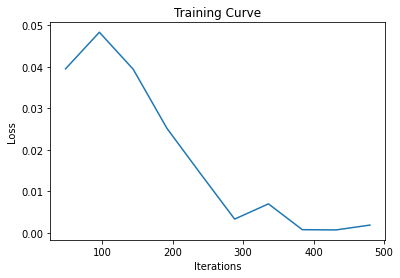

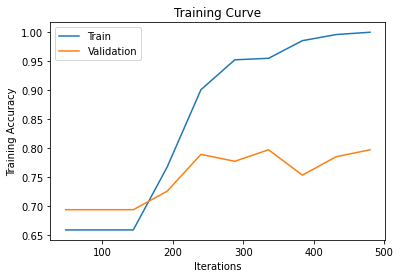

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.796812749003984


([0.6582781456953642,
  0.6582781456953642,
  0.6582781456953642,
  0.766887417218543,
  0.9006622516556292,
  0.952317880794702,
  0.9549668874172186,
  0.9854304635761589,
  0.9960264900662251,
  1.0],
 [0.6932270916334662,
  0.6932270916334662,
  0.6932270916334662,
  0.7250996015936255,
  0.7888446215139442,
  0.7768924302788844,
  0.796812749003984,
  0.7529880478087649,
  0.7848605577689243,
  0.796812749003984])

In [ ]:
model_100 = ResponseRNN(input_size=len(text_field.vocab), hidden_size=25, num_classes=2)
train_rnn_network(model_100, train, valid, batch_size=16, num_epochs=10, learning_rate=1e-3)

Training Started...
0 0.6582781456953642 0.6932270916334662
1 0.6582781456953642 0.6932270916334662
2 0.6582781456953642 0.6932270916334662
3 0.6993377483443709 0.7450199203187251
4 0.9033112582781457 0.7250996015936255
5 0.9390728476821192 0.7529880478087649
6 0.9655629139072848 0.7689243027888446
7 0.9576158940397351 0.6892430278884463
8 0.9867549668874173 0.7529880478087649
9 0.9933774834437086 0.7768924302788844


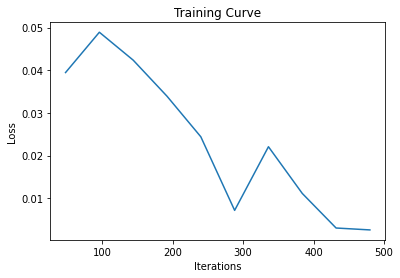

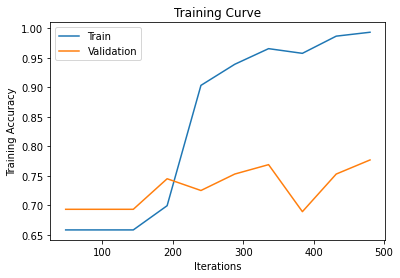

Final Training Accuracy: 0.9933774834437086
Final Validation Accuracy: 0.7768924302788844


([0.6582781456953642,
  0.6582781456953642,
  0.6582781456953642,
  0.6993377483443709,
  0.9033112582781457,
  0.9390728476821192,
  0.9655629139072848,
  0.9576158940397351,
  0.9867549668874173,
  0.9933774834437086],
 [0.6932270916334662,
  0.6932270916334662,
  0.6932270916334662,
  0.7450199203187251,
  0.7250996015936255,
  0.7529880478087649,
  0.7689243027888446,
  0.6892430278884463,
  0.7529880478087649,
  0.7768924302788844])

In [ ]:
model_10 = ResponseRNN(input_size=len(text_field.vocab), hidden_size=18, num_classes=2)
train_rnn_network(model_10, train, valid, batch_size=16, num_epochs=10, learning_rate=1e-3)

In [ ]:
torch.save(model_10.state_dict(), '/content/drive/My Drive/Colab Notebooks/UnERD/Model_V2/Saves/model_10.pt')

In [ ]:
model = ResponseRNN(input_size=len(text_field.vocab), hidden_size=25, num_classes=2)
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/UnERD/Model_V2/Saves/model_10.pt'))
model.eval()



```
# Specify a path
PATH = "state_dict_model.pt"

# Save
torch.save(net.state_dict(), PATH)

# Load
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()
```



In [ ]:
torch.save(model_11.state_dict(), '/content/drive/My Drive/Colab Notebooks/UnERD/Model_V2/Saves/model_10.pt')

In [ ]:
model = ResponseRNN(input_size=len(text_field.vocab), hidden_size=25, num_classes=2)
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/UnERD/Model_V2/Saves/model_10.pt'))
model.eval()

In [ ]:
# Do the test set now:
test_accuracy = get_accuracy(model, test)
print("The Test Accuracy is: {}".format(test_accuracy))

The Test Accuracy is: 0.8055555555555556


Training Started...
0 0.6437086092715232 0.6932270916334662
1 0.6437086092715232 0.6932270916334662
2 0.6437086092715232 0.6932270916334662
3 0.6437086092715232 0.6932270916334662
4 0.6437086092715232 0.6932270916334662
5 0.6437086092715232 0.6932270916334662
6 0.6437086092715232 0.6932270916334662
7 0.7072847682119205 0.7211155378486056
8 0.7841059602649006 0.601593625498008
9 0.9059602649006623 0.7529880478087649
10 0.928476821192053 0.7330677290836654
11 0.9615894039735099 0.7808764940239044
12 0.9655629139072848 0.7928286852589641
13 0.9774834437086093 0.7689243027888446
14 0.9867549668874173 0.8087649402390438


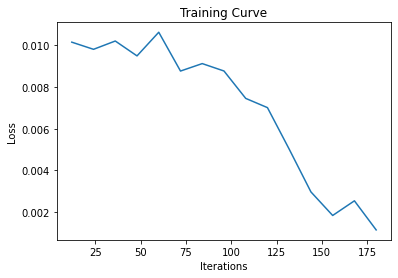

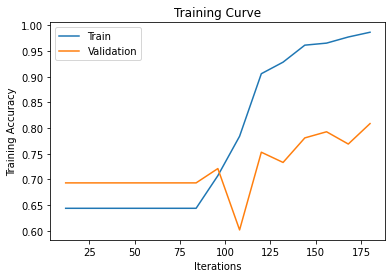

Final Training Accuracy: 0.9867549668874173
Final Validation Accuracy: 0.8087649402390438


([0.6437086092715232,
  0.6437086092715232,
  0.6437086092715232,
  0.6437086092715232,
  0.6437086092715232,
  0.6437086092715232,
  0.6437086092715232,
  0.7072847682119205,
  0.7841059602649006,
  0.9059602649006623,
  0.928476821192053,
  0.9615894039735099,
  0.9655629139072848,
  0.9774834437086093,
  0.9867549668874173],
 [0.6932270916334662,
  0.6932270916334662,
  0.6932270916334662,
  0.6932270916334662,
  0.6932270916334662,
  0.6932270916334662,
  0.6932270916334662,
  0.7211155378486056,
  0.601593625498008,
  0.7529880478087649,
  0.7330677290836654,
  0.7808764940239044,
  0.7928286852589641,
  0.7689243027888446,
  0.8087649402390438])

In [ ]:
model_14 = ResponseRNN(input_size=len(text_field.vocab), hidden_size=25, num_classes=2)
train_rnn_network(model_14, train, valid, batch_size=64, num_epochs=15, learning_rate=1e-3)

Training Started...
0 0.6582781456953642 0.6932270916334662
1 0.6582781456953642 0.6932270916334662
2 0.6582781456953642 0.6932270916334662
3 0.6582781456953642 0.6932270916334662
4 0.6582781456953642 0.6932270916334662
5 0.6582781456953642 0.6932270916334662
6 0.6582781456953642 0.6932270916334662
7 0.6582781456953642 0.6932270916334662
8 0.6609271523178808 0.6972111553784861
9 0.7960264900662252 0.7330677290836654
10 0.8291390728476821 0.7370517928286853
11 0.8105960264900662 0.6254980079681275
12 0.871523178807947 0.6892430278884463
13 0.8821192052980132 0.7450199203187251
14 0.9205298013245033 0.7569721115537849
15 0.9245033112582781 0.7330677290836654
16 0.9364238410596026 0.7370517928286853
17 0.9470198675496688 0.7410358565737052
18 0.9589403973509933 0.7529880478087649
19 0.9668874172185431 0.7569721115537849
20 0.9682119205298013 0.7649402390438247
21 0.9748344370860927 0.7729083665338645
22 0.9748344370860927 0.7768924302788844
23 0.9417218543046357 0.7569721115537849
24 0.98

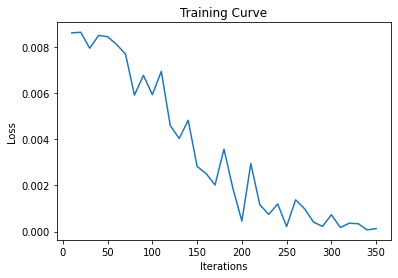

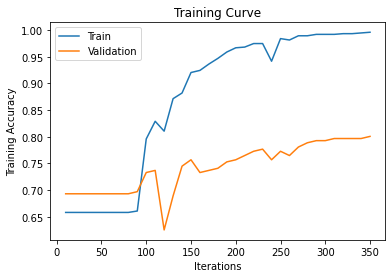

Final Training Accuracy: 0.9960264900662251
Final Validation Accuracy: 0.8007968127490039


([0.6582781456953642,
  0.6582781456953642,
  0.6582781456953642,
  0.6582781456953642,
  0.6582781456953642,
  0.6582781456953642,
  0.6582781456953642,
  0.6582781456953642,
  0.6609271523178808,
  0.7960264900662252,
  0.8291390728476821,
  0.8105960264900662,
  0.871523178807947,
  0.8821192052980132,
  0.9205298013245033,
  0.9245033112582781,
  0.9364238410596026,
  0.9470198675496688,
  0.9589403973509933,
  0.9668874172185431,
  0.9682119205298013,
  0.9748344370860927,
  0.9748344370860927,
  0.9417218543046357,
  0.9841059602649007,
  0.9814569536423841,
  0.9894039735099338,
  0.9894039735099338,
  0.9920529801324504,
  0.9920529801324504,
  0.9920529801324504,
  0.9933774834437086,
  0.9933774834437086,
  0.9947019867549669,
  0.9960264900662251],
 [0.6932270916334662,
  0.6932270916334662,
  0.6932270916334662,
  0.6932270916334662,
  0.6932270916334662,
  0.6932270916334662,
  0.6932270916334662,
  0.6932270916334662,
  0.6972111553784861,
  0.7330677290836654,
  0.737051

In [ ]:
model_14 = ResponseRNN(input_size=len(text_field.vocab), hidden_size=10, num_classes=2)
train_rnn_network(model_14, train, valid, batch_size=80, num_epochs=35, learning_rate=1e-3)

# Real Data

Sentiment Analysis on New Responses

In [ ]:
def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

In [ ]:
glove = torchtext.vocab.GloVe(name="6B", dim=50)

.vector_cache/glove.6B.zip: 862MB [06:42, 2.14MB/s]                          
100%|█████████▉| 399469/400000 [00:14<00:00, 26884.77it/s]

In [ ]:
def get_new_tweet(glove_vector, sample_tweet):
    tweet = sample_tweet
    idxs = [glove_vector.stoi[w]        # lookup the index of word
            for w in split_tweet(tweet)
            if w in glove_vector.stoi] # keep words that has an embedding
    idxs = torch.tensor(idxs) # convert list to pytorch tensor
    return idxs

In [ ]:
new_tweet = get_new_tweet(glove, "This is bad")
print(new_tweet.shape)

out = torch.sigmoid(model(new_tweet.unsqueeze(0)))
pred = out.max(1, keepdim=True)[1]
print(pred)

torch.Size([3])
tensor([[2]])


In [ ]:
new_tweet = get_new_tweet(glove, "This is the best day of my life")
print(new_tweet.shape)

out = torch.sigmoid(model(new_tweet.unsqueeze(0)))
pred = out.max(1, keepdim=True)[1]
print(pred)

torch.Size([8])
tensor([[2]])
